# Imports & Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
from PIL import Image
from termcolor import colored
import glob
from typing import List, Tuple

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


### Load Data

In [ ]:
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset
!unzip /content/pothole-detection-dataset.zip -d /content/Data

DATA_DIR = r"/content/Data"

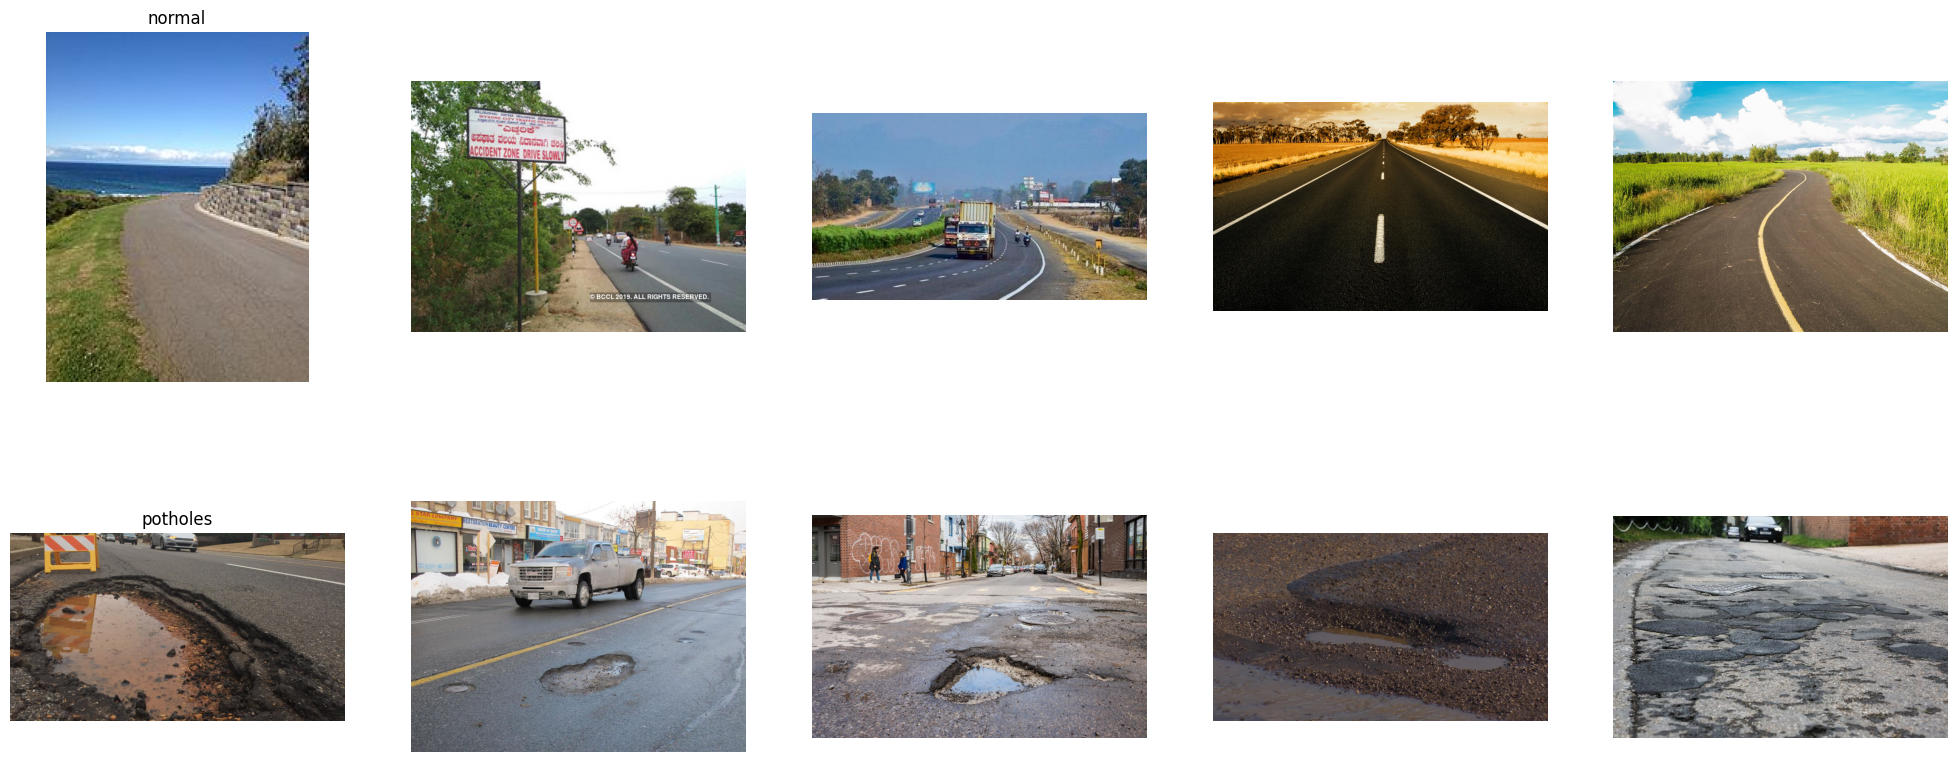

In [ ]:
def visualize_multiclass_from_dir(data_dir: str, samples:int = 5)->None:
  """
  Visualizes a random sample of images from multiple classes stored in directories.

  Parameters:
    data_dir (str): The root directory containing subdirectories for each class, where each subdirectory contains images for that class.
    samples (int, optional) :  The number of images to randomly sample and display from each class.

  Returns:
  None

  Displays a grid of images with one row per class and one column per sample.
  Note: This function is intended for multiclass datasets organized with a separate folder for each class.
  """
  classes = os.listdir(data_dir)
  fig, ax = plt.subplots(len(classes), samples, figsize=(5*samples, 5*len(classes)))
  for i, cls in enumerate(classes):
    cls_dir = os.path.join(data_dir, cls)
    img_paths = os.listdir(cls_dir)
    for j in range(samples):
      idx = np.random.randint(0, len(img_paths))
      img_path = os.path.join(cls_dir, img_paths[idx])
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax[i, j].imshow(img)
      ax[i, j].axis('off')
    ax[i, 0].set_title(cls)
  # plt.tight_layout()
  plt.show()

visualize_multiclass_from_dir(data_dir=DATA_DIR)

Loaded 680 with 1 errors


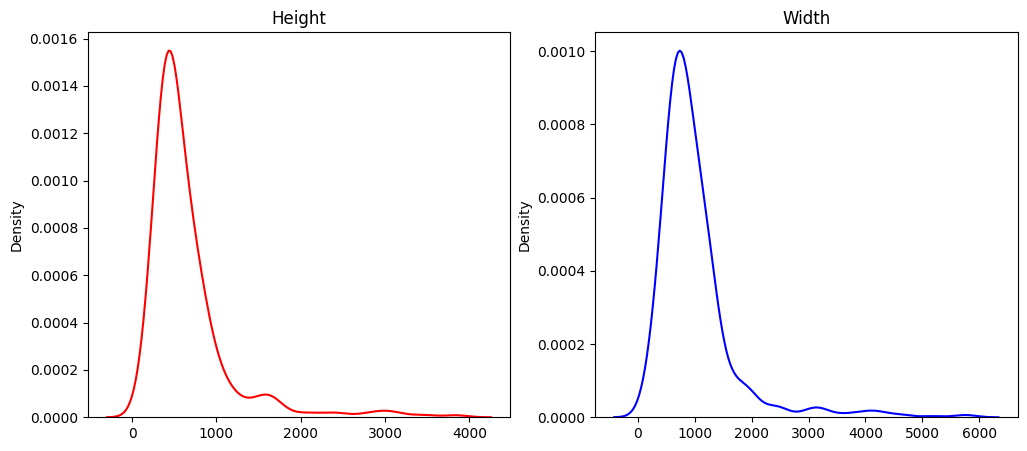

In [ ]:
def clrd(text: str, color: str = None):
    color_codes = {
        'ok': '\033[92m',        # Green
        'error': '\033[91m',     # Red
        'warning': '\033[93m',   # Yellow
        'success': '\033[92m',   # Green
        'status': '\033[95m',    # Magenta
        'special': '\033[94m',   # Blue
        'log': '\033[96m',       # Cyan
        'reset': '\033[0m'       # Reset to default color
    }
    color_code = color_codes.get(color, color_codes['reset'])
    return f"{color_code}{text}{color_codes['reset']}"

def analyze_img_dimensions(data_dir: str, extension:str = ".jpg")->None:
  shapes, misses = [], 0
  for file in glob.glob(os.path.join(data_dir, f'*/*{extension}')):
    try:
      img = cv2.imread(os.path.join(data_dir, file))
      shapes.append(img.shape)
    except Exception as e:
      misses += 1
  if misses == 0:
    print(clrd(f"Loaded {len(shapes)} with {misses} errors", "status"))
  else:
    print(clrd(f"Loaded {len(shapes)} with {misses} errors", "warning"))
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  sns.kdeplot([shape[0] for shape in shapes], ax=ax[0], color='red')
  sns.kdeplot([shape[1] for shape in shapes], ax=ax[1], color='blue')
  ax[0].set_title('Height')
  ax[1].set_title('Width')
  plt.show()

analyze_img_dimensions(DATA_DIR)

### Torch Transforms

In [ ]:
from torchvision.transforms import v2

transforms_dict = {
    'perspective': v2.RandomPerspective(distortion_scale=0.3, p=1.0),
    'rotation': v2.RandomRotation(degrees=(0, 30)),
    'affine': v2.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    'elastic': v2.ElasticTransform(alpha=250.0),
    'gaussian': v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    'posterize': v2.RandomPosterize(bits=2),
    'sharpness': v2.RandomAdjustSharpness(sharpness_factor=2),
    'equalize': v2.RandomEqualize(),
    'color_jitter': v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    'h_flip': v2.RandomHorizontalFlip(p=0.5),
    'v_flip': v2.RandomVerticalFlip(p=0.5),
}

img = Image.open(r"/content/Data/potholes/151.jpg")
n = len(transforms_dict)+1
cols = 3
fig, ax = plt.subplots((n+cols-1)//cols, cols, figsize=(25, 5*((n+cols-1)//cols)))
ax.flatten()[0].imshow(img)
ax.flatten()[0].axis('off')
for i, (name, transform) in enumerate(transforms_dict.items()):
  ax.flatten()[i+1].imshow(transform(img))
  ax.flatten()[i+1].axis('off')
  ax.flatten()[i+1].set_title(name)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.9, 1.0)),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

In [ ]:
val_split = 0.1
dataset_size = len(dataset)
train_dataset, val_dataset = random_split(dataset, [len(dataset)-int(len(dataset)*val_split), int(len(dataset)*val_split)])
val_dataset.dataset.transform = val_transforms

# Train Model

In [ ]:
class ImageClassifier(torch.nn.Module):

  class ConvBlock(torch.nn.Module):
      def __init__(self, in_channels, out_channels, activation = torch.nn.ReLU, dropout = 0.1):
            super().__init__()
            self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn = torch.nn.BatchNorm2d(out_channels)
            self.activation = activation()
            self.pool = torch.nn.MaxPool2d(kernel_size=2)
            self.dropout = torch.nn.Dropout2d(dropout)

      def forward(self, x):
            x = self.conv(x)
            x = self.bn(x)
            x = self.activation(x)
            x = self.pool(x)
            x = self.dropout(x)
            return x

      def get_dims(self, shape: Tuple[int, int]):
          h = (shape[0] + 2*1 - 1*(3-1) - 1) // 1 + 1  # Convolution output height
          w = (shape[1] + 2*1 - 1*(3-1) - 1) // 1 + 1  # Convolution output width
          h = h // 2                                   # MaxPool output height
          w = w // 2                                   # MaxPool output width
          return h, w

  def __init__(self, num_classes:int, input_dims:Tuple[int, int]=(256, 256))->None:
    super().__init__()
    self.conv1 = self.ConvBlock(in_channels=3, out_channels=32)
    self.conv2 = self.ConvBlock(in_channels=32, out_channels=64)
    self.conv3 = self.ConvBlock(in_channels=64, out_channels=128)

    h, w = self.conv3.get_dims(self.conv2.get_dims(self.conv1.get_dims(input_dims)))
    dims = 128*h*w
    self.fc1 = torch.nn.Linear(in_features=dims, out_features=512)
    self.fc2 = torch.nn.Linear(in_features=512, out_features=num_classes)
    self.dropout = torch.nn.Dropout(0.5)

    self.activation = torch.nn.LeakyReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
from torchsummary import summary

INPUT_DIMS = (256, 256)
EPOCHS = 20
BATCH_SIZE = 64
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = ImageClassifier(num_classes=NUM_CLASSES, input_dims=INPUT_DIMS).to(DEVICE)
summary(model, input_size=(3,)+INPUT_DIMS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
         Dropout2d-5         [-1, 32, 128, 128]               0
         ConvBlock-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
        Dropout2d-11           [-1, 64, 64, 64]               0
        ConvBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
      BatchNorm2d-14          [-1, 128,

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, mode='min'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = float('inf') if mode == 'min' else 0

    def early_stop(self, score)->bool:
        if self.mode == 'min':
          self.best_score = min(self.best_score, score)
          if self.best_score - score < -self.delta:
            self.counter += 1
            if self.counter >= self.patience:
              return True
        else:
          self.best_score = min(self.best_score, score)
          if self.best_score - score > self.delta:
            self.counter += 1
            if self.counter >= self.patience:
              return True
        return False

class Logger:
  def __init__(self, train_loader, metrics = ['loss', 'accuracy']):
    self.history = {
        "train": [],
        "val": []
    }
    self.n = len(train_loader)
    self.interval = self.n//10
    self.epochs = 0
    self.__header__()

  def start(self):
    self.epochs += 1
    self.steps = 0
    print("{:<7}".format(self.epochs), "| ", end='')

  def step(self):
    if self.steps % self.interval == 0:
        print(clrd('|', 'ok'), end='')
    self.steps += 1

  def update(self, train_loss, val_loss):
    self.history["train"].append(train_loss)
    self.history["val"].append(val_loss)
    print("   |", " {:<10}".format(str(self.history["train"][-1])[:10]), "|", "{:<10}".format(str(self.history["val"][-1])[:10]))

  def plot(self):
    plt.plot(self.history["train"], label="train")
    plt.plot(self.history["val"], label="val")
    plt.legend()
    plt.show()

  def __header__(self):
    print('='*100)
    print("{:<7}".format(f'EPOCHS '), "|", "{:<12}".format('STATUS'), "|"," {:<10}".format('TRAIN'), "|", "{:<10}".format('VAL'))
    print('='*100)

In [ ]:
model.to(DEVICE)
lg = Logger(train_loader=train_loader)
early_stopping = EarlyStopping(patience=5)

for epoch in range(EPOCHS):
  running_train_loss, running_val_loss = 0.0, 0.0
  lg.start()
  for inputs, targets in train_loader:
    lg.step()
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    running_train_loss += loss.item()

  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      running_val_loss += loss.item()

  lg.update(running_train_loss/len(train_loader), running_val_loss/len(val_loader))
  if early_stopping.early_stop(running_val_loss/len(val_loader)):
    print(clrd(f"Early stopping triggered at epoch {epoch}", 'special'))
    break

EPOCHS  | STATUS       |  TRAIN      | VAL       
1       | ||||||||||   |  41.4801097 | 5.12514233
2       | ||||||||||   |  4.73426063 | 2.53151714
3       | ||||||||||   |  2.18646900 | 2.50701749
4       | ||||||||||   |  1.11771527 | 1.48581689
5       | ||||||||||   |  0.65453281 | 0.36647535
6       | ||||||||||   |  0.31458060 | 0.53026033
7       | ||||||||||   |  0.32831564 | 0.86776289
8       | ||||||||||   |  0.30575988 | 0.54895859
9       | ||||||||||   |  0.23692258 | 0.53757898
10      | ||||||||||   |  0.24787049 | 0.37177930
Early stopping triggered at epoch 9


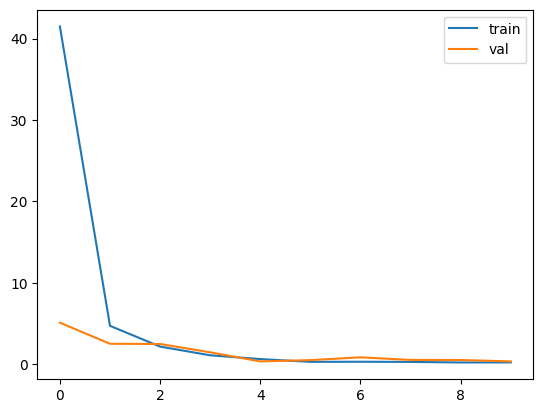

In [ ]:
lg.plot()